# Supervised Anomaly Detection Analysis

## Project Overview
This notebook is part of a project aimed at detecting anomalies in web authentication systems using machine learning techniques. Anomalies in web authentication can indicate potential security threats such as unauthorized access attempts or system failures. This notebook specifically focuses on a **supervised approach** to identify such anomalies, employing both classical and advanced machine learning models.

## Dataset Description
The data used in this project is synthetically generated to simulate real-world web authentication logs. It includes features such as user IDs, login status, IP addresses, device types, and session durations. This controlled synthetic environment allows us to model and identify unusual patterns indicative of authentication anomalies.

## Objectives
- **Generate a Synthetic Dataset**: Create a synthetic dataset that mimics real-world web authentication logs.
- **Implement Supervised Machine Learning Models**: Deploy various supervised learning models to classify activities as normal or anomalous, based on learned patterns from the data.
- **Evaluate Model Effectiveness**: Assess the performance of each model to determine their effectiveness in accurately identifying anomalies.

# Setup and Configuration

In [11]:
# Importing Necessary Libraries
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
seed = 50
np.random.seed(seed)

# Display settings for this notebook
pd.set_option('display.max_columns', None)
plt.style.use('ggplot') 
sns.set(style="whitegrid")

print("Setup complete.")


Setup complete.


# Data Generation

This section focuses on generating synthetic data to simulate web authentication logs. This synthetic approach allows us to model a wide variety of scenarios that might not be readily available in publicly accessible datasets due to privacy concerns. Each feature included in the dataset serves a specific purpose in replicating real-world conditions and behaviors:

- **User ID**: Represents individual users within the system, each with unique behavior patterns.

- **Timestamps**: Generated to cover a full year, providing temporal context to each session.

- **Login Status**: Indicates whether a login attempt was successful or failed. This feature is critical, as failed login attempts can be a strong indicator of unauthorized access attempts.

- **IP Addresses**: Includes both common and uncommon IP addresses. The diversity in IP addresses helps to differentiate between normal user logins and potentially malicious attempts from rare or unusual locations.

- **Device Types**: Reflects the variety of devices that could access the system, such as desktops, mobile phones, and tablets.

- **Locations**: Ranges from typical to atypical locations (e.g., USA, Canada, Mars, Antarctica). Anomalous locations can be a significant factor in detecting unusual activities.

- **Session Duration**: Measures the length of time a session remains active.

- **Failed Attempts**: Counts the number of unsuccessful login attempts during a session. A high number of failed attempts could signal a brute force attack or other malicious activities.

- **Behavioral Scores**: Quantitative scores assigned based on user behavior during a session.

- **Anomaly Labels**: Derived from predefined conditions based on the other features, such as excessive session durations, high numbers of failed attempts, extremely low or high behavioral scores, and logins from rare IPs or unusual locations.

By generating such synthetic data, this project aims to develop robust anomaly detection models that can be later adapted to real data.

In [12]:
# Hyperparameters for Data Generation

num_users = 1000  # Total number of users
num_records = 10000  # Total number of records
anomaly_rate = 0.05  # Percentage of records that are anomalies
success_login_rate = 0.95  # Percentage of login attempts that are successful
uncommon_ip_prob = 0.03  # Probability of an uncommon IP address being chosen
failed_attempt_limit = 5  # Threshold for failed login attempts to trigger an anomaly
behavioral_score_low = 40  # Lower threshold for behavioral score anomalies
behavioral_score_high = 120  # Upper threshold for behavioral score anomalies

In [13]:
# Generating synthetic data

# Generate user IDs
user_ids = np.random.choice(range(1, num_users + 1), num_records)

# Generate timestamps over the last year
timestamps = pd.date_range(start=datetime.now() - timedelta(days=365), periods=num_records, freq='min')

# Simulating Login Successes
login_statuses = np.random.choice(['Success', 'Fail'], num_records, p=[success_login_rate, 1 - success_login_rate])

# Generate IP addresses
common_ips = [f'192.168.1.{i}' for i in np.random.randint(10, 100, 10)]
uncommon_ips = [f'10.10.10.{i}' for i in np.random.randint(1, 10, 3)]
total_ips = common_ips + uncommon_ips
probabilities = [(1 - uncommon_ip_prob) / len(common_ips)] * len(common_ips) + [uncommon_ip_prob / len(uncommon_ips)] * len(uncommon_ips)
ip_addresses = np.random.choice(total_ips, num_records, p=probabilities)

# Define possible device types
device_types = ['Desktop', 'Mobile', 'Tablet']
devices = np.random.choice(device_types, num_records)

# Define normal Locations
locations = np.random.choice(['USA', 'Canada', 'Germany', 'Japan', 'Antarctica', 'Mars'], num_records, p=[0.24, 0.24, 0.24, 0.24, 0.02, 0.02])

# Generate session durations and behavioral scores
session_durations = np.where(login_statuses == 'Success', np.random.exponential(scale=300, size=num_records), 0)
failed_attempts = np.where(login_statuses == 'Fail', np.random.poisson(lam=2, size=num_records), 0)
behavioral_scores = np.where(login_statuses == 'Success', np.random.normal(loc=80, scale=10, size=num_records), np.random.normal(loc=50, scale=10, size=num_records))

# Define anomalies based on specific conditions
anomaly_conditions = (
    (failed_attempts > failed_attempt_limit) |
    (behavioral_scores < behavioral_score_low) |
    (behavioral_scores > behavioral_score_high) |
    (session_durations > 3 * np.mean(session_durations)) |
    (session_durations < 5) |
    (np.isin(ip_addresses, uncommon_ips)) |
    (np.isin(locations, ['Antarctica', 'Mars']))
)
anomaly_labels = anomaly_conditions.astype(int)

# Compile all features into a DataFrame
df = pd.DataFrame({
    'User ID': user_ids,
    'Timestamp': timestamps,
    'Login Status': login_statuses,
    'IP Address': ip_addresses,
    'Device Type': devices,
    'Location': locations,
    'Session Duration': session_durations,
    'Failed Attempts': failed_attempts,
    'Behavioral Score': behavioral_scores,
    'Anomaly': anomaly_labels
})

# Save the DataFrame to the data directory
os.makedirs('data', exist_ok=True)
file_path = os.path.join('data', 'synthetic_web_auth_logs.csv')
df.to_csv(file_path, index=False)
print(f"Data saved successfully to '{file_path}'.")

df.head()

Data saved successfully to 'data/synthetic_web_auth_logs.csv'.


,User ID,Timestamp,Login Status,IP Address,Device Type,Location,Session Duration,Failed Attempts,Behavioral Score,Anomaly
0,689,2023-08-24 13:54:05.070296,Success,192.168.1.14,Desktop,Canada,7.439981,0,88.550647,0
1,481,2023-08-24 13:55:05.070296,Success,192.168.1.25,Mobile,Germany,400.523324,0,92.295306,0
2,908,2023-08-24 13:56:05.070296,Success,192.168.1.54,Tablet,Canada,298.019279,0,81.044294,0
3,110,2023-08-24 13:57:05.070296,Success,192.168.1.27,Mobile,USA,0.020560,0,97.926740,1
4,290,2023-08-24 13:58:05.070296,Success,192.168.1.27,Mobile,Germany,409.528331,0,71.393190,0


# Data Exploration

In this section, the focus is on the synthetic dataset generated in the previous step to understand its features, particularly the aspects that could influence anomaly detection.

In [14]:
# Checking for missing values and basic info
df.info()
print("\nMissing values in each column:\n", df.isnull().sum())
print("\nDescriptive Statistics by Anomaly Status:")
print(df.groupby('Anomaly').describe())

# Check the balance of anomalies
print("\nAnomaly Ratio (%):")
print(df['Anomaly'].value_counts(normalize=True) * 100)

# Check relationships between features
df_temp = df.copy()  # Create a temporary copy of the DataFrame
df_temp['Login Status'] = df_temp['Login Status'].map({'Success': 1, 'Fail': 0})
correlation_matrix = df_temp.select_dtypes(include=[np.number]).corr()
print("\nCorrelation Matrix of all features:\n", correlation_matrix)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   User ID           10000 non-null  int64         
 1   Timestamp         10000 non-null  datetime64[ns]
 2   Login Status      10000 non-null  object        
 3   IP Address        10000 non-null  object        
 4   Device Type       10000 non-null  object        
 5   Location          10000 non-null  object        
 6   Session Duration  10000 non-null  float64       
 7   Failed Attempts   10000 non-null  int64         
 8   Behavioral Score  10000 non-null  float64       
 9   Anomaly           10000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 781.4+ KB

Missing values in each column:
 User ID             0
Timestamp           0
Login Status        0
IP Address          0
Device Type         0
Location          

As expected, all 10 attributes in the dataset have 10,000 non-null entries. These attributes employ a variety of data types, including integers, floating-point numbers, strings, and datetime objects, to accurately represent session details. Also, it can be seen that approximately 18.15% of the sessions are flagged as anomalies.

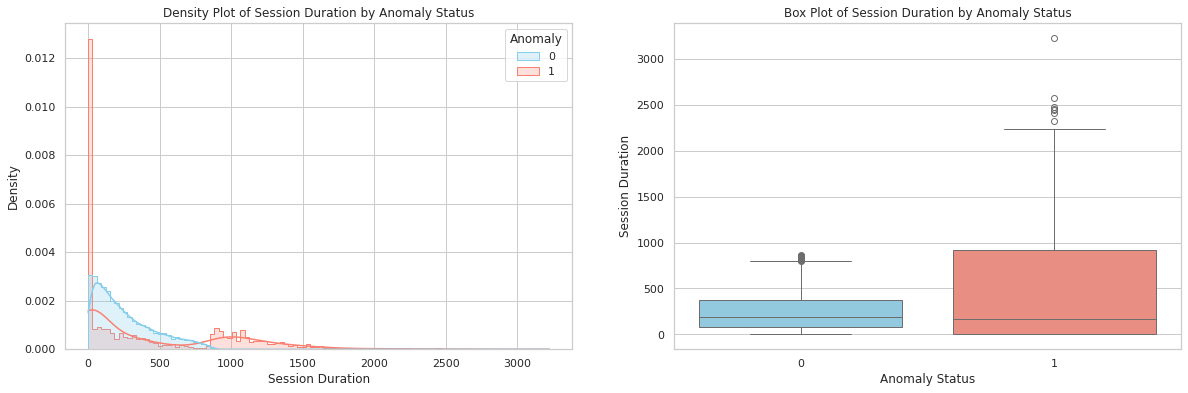

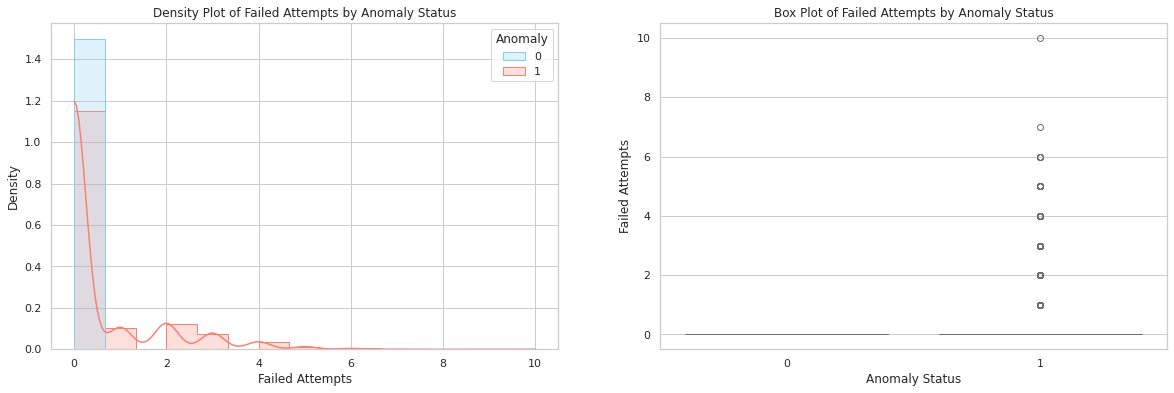

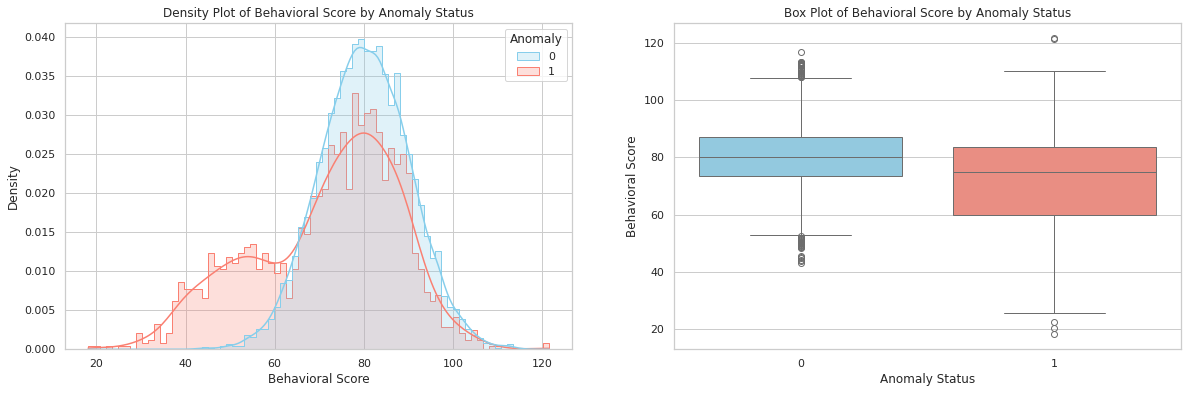

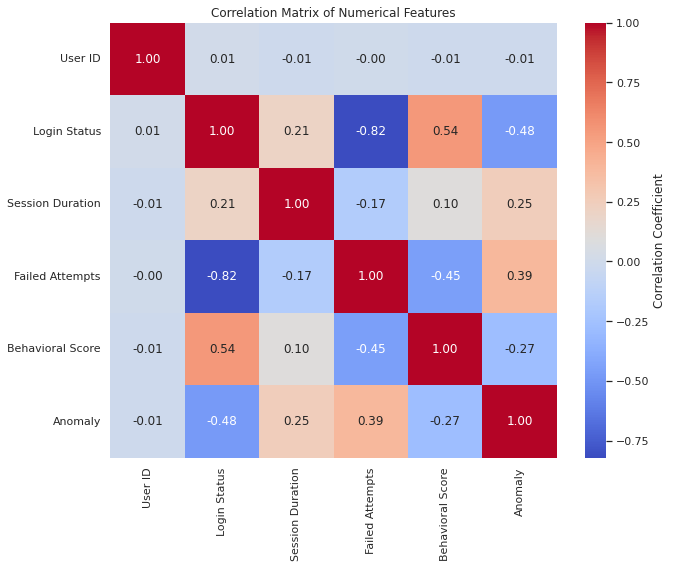

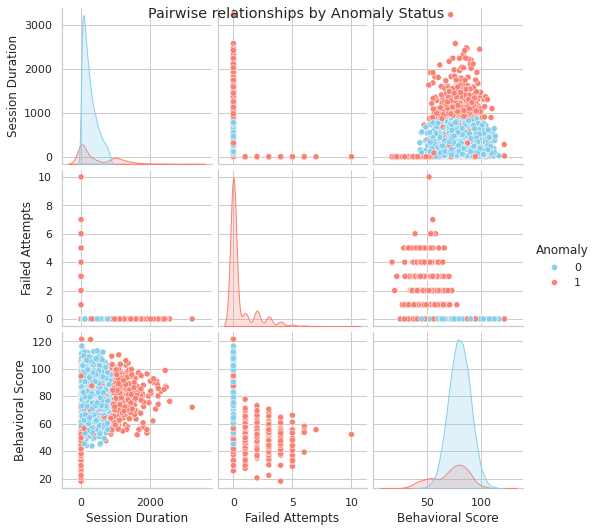

In [15]:
# Visualization

# Density and box plots for numerical features by anomaly status
numerical_features = ['Session Duration', 'Failed Attempts', 'Behavioral Score']
for feature in numerical_features:
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)  # Density plot
    sns.histplot(data=df, x=feature, hue='Anomaly', element='step', stat='density', common_norm=False, kde=True, palette={0: 'skyblue', 1: 'salmon'})
    plt.title(f'Density Plot of {feature} by Anomaly Status')
    plt.xlabel(feature)
    plt.ylabel('Density')
    
    plt.subplot(1, 2, 2)  # Box plot
    # sns.boxplot(x='Anomaly', y=feature, data=df)
    sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})
    plt.title(f'Box Plot of {feature} by Anomaly Status')
    plt.xlabel('Anomaly Status')
    plt.ylabel(feature)
    plt.show()

# Heatmap for the correlation matrix of numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Pairplot for pairwise relationships, segmented by Anomaly status
sns.pairplot(df, hue='Anomaly', vars=numerical_features, palette={0: 'skyblue', 1: 'salmon'})
plt.suptitle('Pairwise relationships by Anomaly Status', verticalalignment='top')
plt.show()

## Data Analysis

The **density and box Plots** indicate multiple noteworthy insights:
- **Session Duration**: The density plot reveals a sharp peak at very short durations for anomalous sessions, indicating a prevalence of extremely brief interactions typical of anomalies. In contrast, normal sessions show a much more gradual decline in density, suggesting that legitimate user sessions vary widely in length, accommodating a range of typical user activities. The box plot for anomalous sessions shows a wide interquartile range, indicating a variability in the duration of these sessions, from very short to unusually long. This could suggest attempts by anomalies to either quickly exploit systems or linger to mimic normal behavior. On the other hand, the box plot for normal sessions is much more compact, highlighting consistent and expected session durations among typical users.
  
- **Failed Attempts**: The density plot for failed attempts illustrates that normal sessions consistently register zero failed attempts, reflecting typical error-free interactions. In contrast, anomalous sessions not only show a peak at zero but also display a spread across higher values, as evident in the broader distribution in the density plot, as well as outliers in the box plot. This variation in failed attempts suggests that while many anomalies may initially mimic normal behavior, some engage in actions that lead to multiple failed attempts. These findings indicate the potential of using failed attempts as a critical metric for distinguishing between normal and abnormal activities.

- **Behavioral Score**: In this score, normal interactions are tightly concentrated around a high median score. On the other hand, anomalies display a broader spectrum of scores, with a notable shift towards lower values but also extending to higher scores, which suggests varying levels of attempts at system interaction. The box plot further emphasizes these insights. Normal sessions exhibit a compact range centered around a higher median, with few outliers. Conversely, the box plot for anomalies reveals a significantly wider interquartile range and a lower median score, along with more outliers at both low and high extremes. This spread indicates that anomalies can range from very poor to exceptionally high behavioral scores.

The **correlation matrix** highlights several interesting relationships:
- 'Failed Attempts' and 'Anomaly' exhibit a moderate positive correlation, suggesting that higher numbers of failed attempts are more frequently associated with anomalous sessions. This supports the idea that repeated login failures can be a strong indicator of anomalous behavior.
- 'Behavioral Score' shows a negative correlation with 'Anomaly', indicating that lower scores are more common in anomalous sessions.

The **pairplot** allows us to observe the pairwise relationships between the features:
- Anomalies with shorter session durations typically display low behavioral scores, reflecting swift identification and termination by security mechanisms. As session durations extend, anomalies often show increased behavioral scores, suggesting that longer-lasting anomalies might gradually adapt their activities to imitate normal user interactions, potentially evading immediate detection.
- Anomalies show a significant variation in behavioral scores even at zero failed attempts, indicating that not all anomalies are directly associated with login failures. Those that do involve failed attempts generally present lower behavioral scores, somehow indicating effective detection of more overtly suspicious activities by security protocols.

# Data Preprocessing

This section covers the preparation of the dataset. Different preprocessing steps are applied to numerical and categorical features to ensure they are appropriately formatted for the machine learning models.

In [16]:
# Define pipelines for numerical and categorical features
numerical_features = ['Session Duration', 'Failed Attempts', 'Behavioral Score']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Device Type', 'Location', 'Login Status', 'IP Address']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

def extract_time_features(x):
    x['hour'] = x['Timestamp'].dt.hour
    x['day_of_week'] = x['Timestamp'].dt.dayofweek
    return x[['hour', 'day_of_week']]
time_transformer = Pipeline(steps=[
    ('time_features', FunctionTransformer(extract_time_features, validate=False)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('time', time_transformer, ['Timestamp'])
    ])

# Splitting the data into training and testing sets and apply transformations
x = df.drop('Anomaly', axis=1)
y = df['Anomaly']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
x_train_prepared = preprocessor.fit_transform(x_train)
x_test_prepared = preprocessor.transform(x_test)


# Model Training and Evaluation

This section focuses on training various machine learning models on the preprocessed data and evaluating their performance to assess the efficacy of each model in distinguishing between normal and anomalous activities.


## Models Training

In [17]:
# Initialize and train the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)
}

model_predictions = {}
for name, model in models.items():
    model.fit(x_train_prepared, y_train)
    predictions = model.predict(x_test_prepared)
    probabilities = model.predict_proba(x_test_prepared)[:, 1]
    model_predictions[name] = {
        'predictions': predictions,
        'probabilities': probabilities
    }
    print(f"{name} trained successfully.")


Logistic Regression trained successfully.
Random Forest trained successfully.
SVM trained successfully.
Neural Network trained successfully.


## Models Evaluation

Evaluation Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1653
           1       1.00      0.84      0.91       347

    accuracy                           0.97      2000
   macro avg       0.98      0.92      0.95      2000
weighted avg       0.97      0.97      0.97      2000



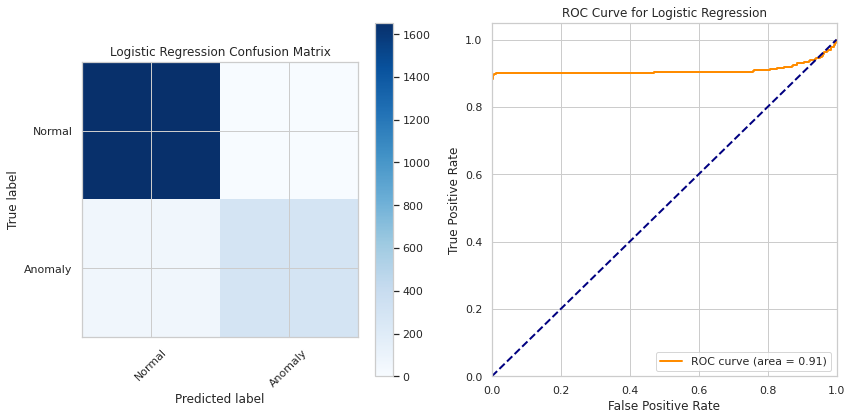

Evaluation Results for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1653
           1       1.00      1.00      1.00       347

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



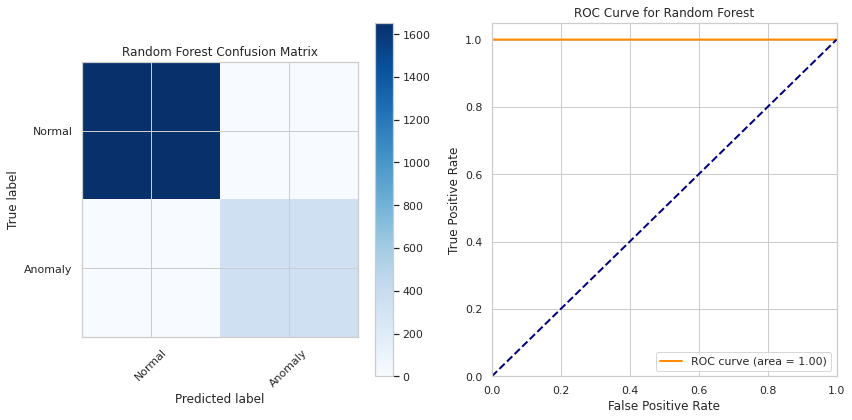

Evaluation Results for SVM:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1653
           1       1.00      0.87      0.93       347

    accuracy                           0.98      2000
   macro avg       0.99      0.94      0.96      2000
weighted avg       0.98      0.98      0.98      2000



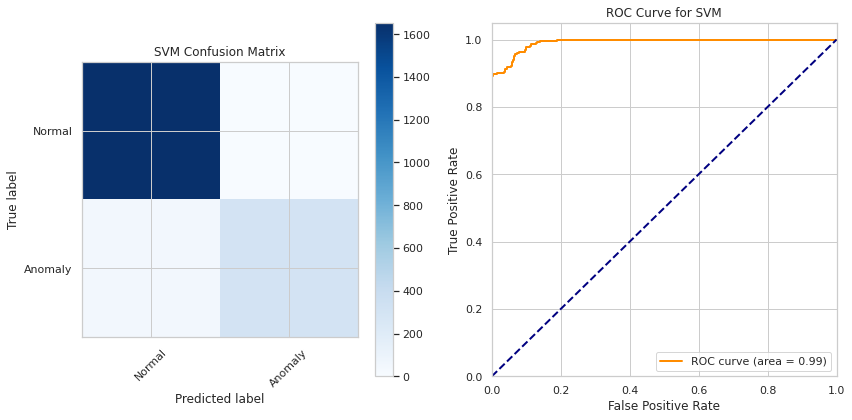

Evaluation Results for Neural Network:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1653
           1       0.98      0.91      0.94       347

    accuracy                           0.98      2000
   macro avg       0.98      0.95      0.97      2000
weighted avg       0.98      0.98      0.98      2000



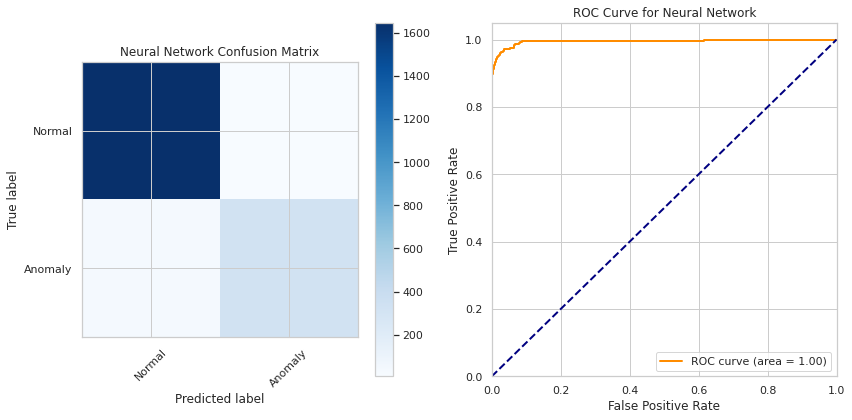

Best performing model: Random Forest with ROC AUC = 1.00


In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curve(fpr, tpr, model, roc_auc):
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model}')
    plt.legend(loc="lower right")

# Evaluate each model
for name, outcomes in model_predictions.items():
    print(f"Evaluation Results for {name}:")
    print(classification_report(y_test, outcomes['predictions']))
    cm = confusion_matrix(y_test, outcomes['predictions'])
    fpr, tpr, _ = roc_curve(y_test, outcomes['probabilities'])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(12, 6))
    plot_confusion_matrix(cm, classes=['Normal', 'Anomaly'], title=f'{name} Confusion Matrix')
    plot_roc_curve(fpr, tpr, name, roc_auc)
    plt.tight_layout()
    plt.show()

# Collect and compare ROC AUC scores
roc_auc_scores = {name: auc(roc_curve(y_test, outcomes['probabilities'])[0],
                             roc_curve(y_test, outcomes['probabilities'])[1])
                  for name, outcomes in model_predictions.items()}
best_model = max(roc_auc_scores, key=roc_auc_scores.get)
print(f"Best performing model: {best_model} with ROC AUC = {roc_auc_scores[best_model]:.2f}")

## Results Analysis

- **Random Forest** exhibited flawless performance with a ROC AUC of 1.00, achieving 100% precision and recall. This model perfectly identified all normal and anomalous sessions without any false negatives or positives, highlighting its robustness and reliability for this specific scenario.

- **Logistic Regression** achieved an overall accuracy of 97%, but exhibited some difficulty in identifying anomalies with a recall of 84%. While it perfectly recognized normal sessions (recall of 1.00), its lower recall for anomalies suggests potential improvements in parameter tuning or feature selection could enhance its sensitivity to outlier behaviors.

- **SVM** also performed robustly, especially in precision, where it achieved 100% in identifying anomalous sessions. However, with a recall of 87% for anomalies, it suggests that while it is excellent at confirming true anomalies, it misses a few, similar to Logistic Regression. This model would be suitable where avoiding false positives is critical.

- **Neural Network** showed a very strong performance with a recall of 92% for anomalies and nearly perfect metrics across other areas. This model's ability to learn complex patterns makes it highly effective, though slightly less so than Random Forest in this scenario.

Overall, this analysis reveals **Random Forest** as the most effective model for this specific scenario, given its ability to perfectly classify both normal and anomalous sessions. The other models, while effective in certain metrics, exhibit trade-offs between precision and recall.